In [1]:
import confirm.outlaw.nb_util as nb_util
nb_util.setup_nb()

import pickle
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
# Run on CPU because a concurrent process is probably running on GPU.
jax.config.update('jax_platform_name', 'cpu')

import confirm.mini_imprint.lewis_drivers as lts
from confirm.lewislib import lewis

import adastate
from criterion import Criterion
from diagnostics import lamstar_histogram

In [2]:
name = '4d'
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)

In [3]:
with open(f"./{name}/data_params.pkl", "rb") as f:
    P, D = pickle.load(f)
load_iter = 'latest'
S, load_iter, fn = adastate.load(name, load_iter)

loading checkpoint 4d/2920.pkl


In [4]:
cr = Criterion(lei_obj, P, S, D)
assert S.twb_max_lam[cr.twb_worst_tile] == np.min(S.twb_max_lam)
assert S.twb_min_lam[cr.twb_worst_tile] == np.min(S.twb_min_lam[cr.ties])

simulation runtime 7.00475001335144
tuning for 524288 simulations with 1 tiles and batch size (1, 16384)


## 11/1/2022

In [5]:
import pandas as pd

In [9]:
# orderer = combined_mean_idx + inflation * (combined_min_idx - combined_mean_idx)
# orderer = S.twb_mean_lam + inflation * (S.twb_min_lam - S.twb_mean_lam)
# orderer[S.twb_mean_lam >= 0.3] = 1.0
# def explore_orderer():
#     sorted_ordering = np.argsort(orderer)
#     sorted_orderer = orderer[sorted_ordering]
#     print(S.db.data[sorted_ordering[:10], S.db.slices['twb_min_lam']])
#     print(S.db.data[sorted_ordering[:10], S.db.slices['twb_mean_lam']])
#     print(S.db.data[sorted_ordering[:1000000], S.db.slices['twb_min_lam']].max())

In [8]:
from IPython.display import display
def tile_report(idxs):
    return pd.DataFrame(
        dict(
            order_idx=np.searchsorted(cr.sorted_orderer, cr.orderer[idxs]),
            twb_min_lam_idx=np.searchsorted(cr.sorted_orderer, S.twb_min_lam[idxs]),
            orderer=cr.orderer[idxs],
            B_lams_min=S.B_lam[idxs].min(axis=1),
            twb_min_lam=S.twb_min_lam[idxs],
            twb_mean_lam=S.twb_mean_lam[idxs],
            twb_max_lam=S.twb_max_lam[idxs],
            orig_lam=S.orig_lam[idxs],
            sim_size=S.sim_sizes[idxs],
            alpha0=S.alpha0[idxs],
            alpha_cost=cr.alpha_cost[idxs]
        )
    )
rpt = tile_report(cr.B_lamss_idx)
rpt['B_lamss'] = cr.B_lamss
rpt.sort_values('B_lamss')

,order_idx,twb_min_lam_idx,orderer,B_lams_min,twb_min_lam,twb_mean_lam,twb_max_lam,orig_lam,sim_size,alpha0,alpha_cost,B_lamss
0,1282708,17143902,0.036498,0.040447,0.066891,0.077021,0.133754,0.078212,2048,0.011112,0.013888,0.040447
25,187517,17093431,0.031678,0.047723,0.066034,0.077486,0.144121,0.072729,2048,0.011012,0.013988,0.047723
21,187517,17093431,0.031678,0.047723,0.066034,0.077486,0.144121,0.072729,2048,0.011012,0.013988,0.047723
20,197001,17521154,0.031732,0.055020,0.074560,0.088836,0.146087,0.086378,4096,0.011022,0.013978,0.055020
15,560947,15785302,0.033575,0.055776,0.058730,0.067116,0.076773,0.066830,8192,0.017187,0.007813,0.055776
3,3136634,17432137,0.041275,0.055952,0.072454,0.082847,0.106373,0.081868,2048,0.017012,0.007988,0.055952
41,1282708,17143902,0.036498,0.040447,0.066891,0.077021,0.133754,0.078212,2048,0.011112,0.013888,0.056609
5,494023,15741666,0.033250,0.056701,0.058538,0.066968,0.097898,0.065488,8192,0.011492,0.013508,0.056701
10,3136634,17432137,0.041275,0.055952,0.072454,0.082847,0.106373,0.081868,2048,0.017012,0.007988,0.056852
8,65777,17027860,0.031000,0.057284,0.064951,0.076268,0.104809,0.076097,4096,0.020640,0.004360,0.057284


In [12]:
display(tile_report([cr.twb_worst_tile]))
cr.twb_worst_tile_lam_min, cr.twb_worst_tile_lam_mean, cr.twb_worst_tile_lam_max

,order_idx,twb_min_lam_idx,orderer,B_lams_min,twb_min_lam,twb_mean_lam,twb_max_lam,orig_lam,sim_size,alpha0,alpha_cost
0,16144974,16970322,0.060412,0.06447,0.064143,0.065387,0.066831,0.065387,524288,0.023828,0.001172


(0.06743614684573143, 0.0686547712368489, 0.07010162657560469)

In [13]:
tile_report(cr.dangerous)

,order_idx,twb_min_lam_idx,orderer,B_lams_min,twb_min_lam,twb_mean_lam,twb_max_lam,orig_lam,sim_size,alpha0,alpha_cost
0,0,17544909,0.013408,0.083289,0.075207,0.095806,0.113960,0.096423,16384,0.017125,0.007875
1,0,17544909,0.013408,0.083289,0.075207,0.095806,0.113960,0.096423,16384,0.017125,0.007875
2,2,17544909,0.013439,0.083289,0.075207,0.095796,0.113960,0.096271,16384,0.017129,0.007871
3,2,17544909,0.013439,0.083289,0.075207,0.095796,0.113960,0.096271,16384,0.017129,0.007871
4,4,17553449,0.014232,0.083295,0.075417,0.095812,0.114556,0.096684,16384,0.017113,0.007887
...,...,...,...,...,...,...,...,...,...,...,...
16379,16336,17049562,0.030718,0.065854,0.065300,0.076827,0.098149,0.074496,4096,0.023838,0.001162
16380,16336,17049562,0.030718,0.065854,0.065300,0.076827,0.098149,0.074496,4096,0.023838,0.001162
16381,16336,17049562,0.030718,0.065854,0.065300,0.076827,0.098149,0.074496,4096,0.023841,0.001159
16382,16336,17049562,0.030718,0.065854,0.065300,0.076827,0.098149,0.074496,4096,0.023841,0.001159


In [19]:
tile_report(cr.refine_dangerous)['sim_size'].min()

262144

In [14]:
overall_rpt = tile_report(S.orig_lam.argsort()[:1000])
overall_rpt

,order_idx,twb_min_lam_idx,orderer,B_lams_min,twb_min_lam,twb_mean_lam,twb_max_lam,orig_lam,sim_size,alpha0,alpha_cost
0,16144974,16970322,0.060412,0.064470,0.064143,0.065387,0.066831,0.065387,524288,0.023828,0.001172
1,16144974,16970322,0.060412,0.064470,0.064143,0.065387,0.066831,0.065387,524288,0.023828,0.001172
2,16144974,16970322,0.060412,0.064470,0.064143,0.065387,0.066831,0.065387,524288,0.023828,0.001172
3,16144974,16970322,0.060412,0.064470,0.064143,0.065387,0.066831,0.065387,524288,0.023828,0.001172
4,16144974,16970322,0.060412,0.064470,0.064143,0.065387,0.066831,0.065387,524288,0.023828,0.001172
...,...,...,...,...,...,...,...,...,...,...,...
995,16324683,17001312,0.061098,0.064897,0.064561,0.065715,0.067155,0.065725,524288,0.023827,0.001173
996,16362929,17006775,0.061247,0.064885,0.064637,0.065767,0.067133,0.065725,524288,0.023831,0.001169
997,16362929,17006775,0.061247,0.064885,0.064637,0.065767,0.067133,0.065725,524288,0.023831,0.001169
998,16317672,17005452,0.061074,0.064922,0.064620,0.065802,0.067374,0.065725,524288,0.023826,0.001174


In [15]:
print('overall_lam', cr.overall_lam)
B_min = S.B_lam.min(axis=1)
bias_bad = B_min < cr.overall_lam
print('n bias bad', np.sum(bias_bad))
n_critical = np.sum((S.orig_lam < cr.overall_lam + 0.01))
n_loose = np.sum(
    (S.orig_lam < cr.overall_lam + 0.01)
    & (P.alpha_target - S.alpha0 > P.grid_target)
)
print(f"number of tiles near critical: {n_critical}")
print(f"    and with loose bounds {n_loose}")
# for i in range(10):
#     dangerous = np.sum(cr.inflated_min_lam[bias_bad] < cr.overall_lam)
#     collateral = np.sum(cr.inflated_min_lam < cr.overall_lam)
#     print(f'inflation factor {i}')
#     print(f'    dangerous tiles caught: {dangerous}')
#     print(f'    collateral tiles caught: {collateral}')

print('lambda**B', cr.B_lamss)
total_effort = np.sum(S.sim_sizes)
for K in np.unique(S.sim_sizes):
    sel = S.sim_sizes == K
    count = np.sum(sel)
    print(f"K={K}:")
    print(f'    count={count / 1e6:.3f}m')
    print(f'    lambda**B[K]={S.B_lam[sel].min(axis=0)}')
    print(f'    min lambda*B[K]={np.min(S.B_lam[sel].min(axis=1)):.4f}')
    print(f'    min lambda*b[K]={np.min(S.twb_min_lam[sel]):.4f}')
    effort = K * count / total_effort
    print(f'    % effort={100 * effort:.4f}') 

overall_lam 0.065387346
n bias bad 1564758
number of tiles near critical: 6546903
    and with loose bounds 753654
lambda**B [0.04044748 0.06277259 0.06186843 0.05595165 0.06519397 0.05670112 0.06335536 0.06433102 0.05728401
 0.05734636 0.05685173 0.06457628 0.06514236 0.05878148 0.06140886 0.05577625 0.06294076 0.06214517
 0.05786111 0.06501589 0.05502006 0.04772288 0.06295992 0.0618218  0.06067661 0.04772288 0.06122842
 0.06214517 0.06176917 0.06552802 0.0618218  0.0657155  0.06186843 0.06360566 0.06273074 0.06541818
 0.06058716 0.06565158 0.05878148 0.0642661  0.06479512 0.05660932 0.05896727 0.06295992 0.06198355
 0.06375528 0.0619594  0.06528723 0.06204975 0.05769911]
K=2048:
    count=0.111m
    lambda**B[K]=[0.04044748 0.06408175 0.06266361 0.05595165 0.0700465  0.06782495 0.06802271 0.0700465  0.07111733
 0.05844139 0.05685173 0.0700465  0.06609207 0.06578129 0.07148298 0.06477027 0.06914044 0.06485405
 0.06493639 0.06732494 0.06746178 0.04772288 0.06485405 0.0618218  0.0655859

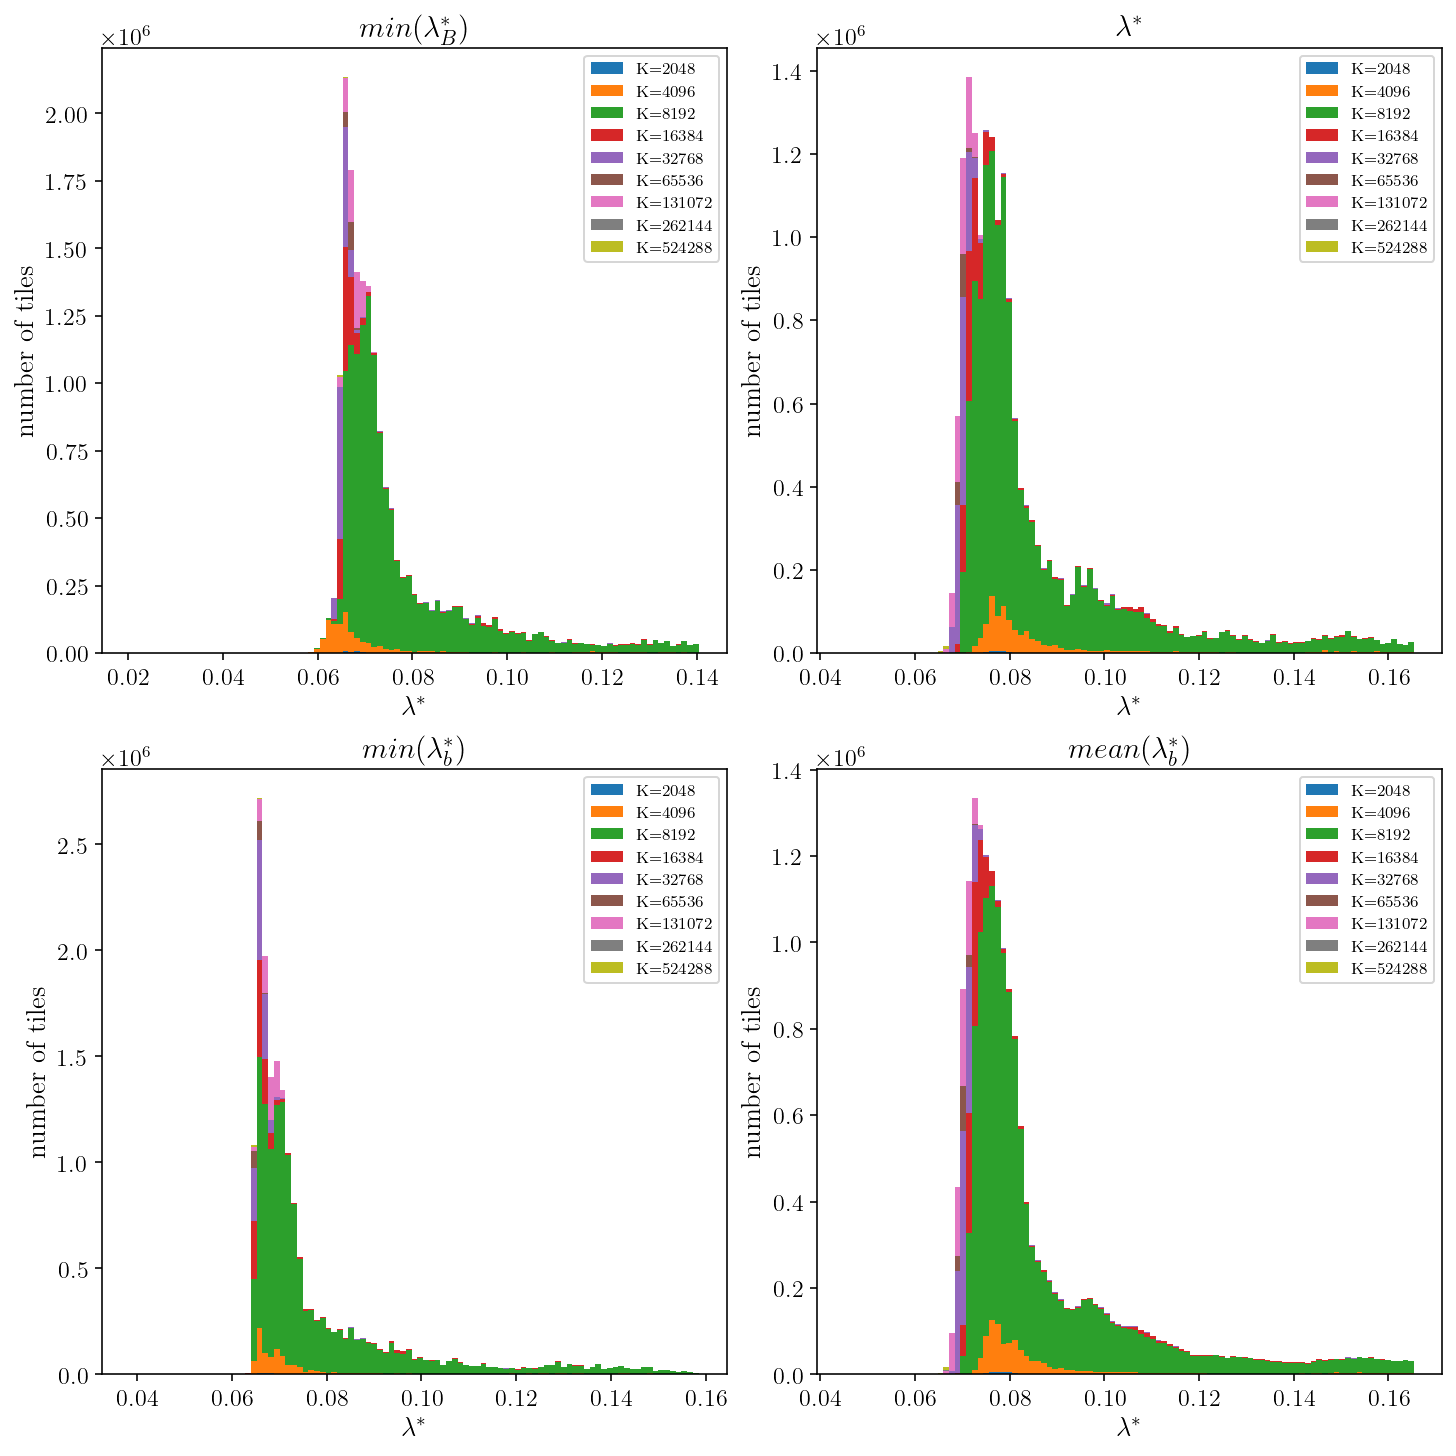

In [16]:
plt.figure(figsize=(10, 10), constrained_layout=True)
plt.subplot(2,2, 1)
plt.title('$min(\lambda^*_B)$')
lamstar_histogram(S.B_lam.min(axis=1), S.sim_sizes)
for i, (field, title) in enumerate([(S.orig_lam, '$\lambda^{*}$'), (S.twb_min_lam, '$min(\lambda^*_b)$'), (S.twb_mean_lam, '$mean(\lambda^*_b)$')]):
    plt.subplot(2,2,i + 2)
    plt.title(title)
    lamstar_histogram(field, S.sim_sizes)
plt.show()

## Scratch

## Resimulation

In [9]:
import pandas as pd
friends = np.where(bootstrap_cvs[:,0] < 0.045)[0]
print(pd.DataFrame(sim_sizes[friends]).describe())
print(pd.DataFrame(pointwise_target_alpha[friends]).describe())

                  0
count  34476.000000
mean    1160.053370
std      564.423262
min     1000.000000
25%     1000.000000
50%     1000.000000
75%     1000.000000
max     8000.000000
                  0
count  34476.000000
mean       0.006419
std        0.002901
min        0.000561
25%        0.004503
50%        0.004715
75%        0.010948
max        0.011460


In [10]:
seed = 0
src_key = jax.random.PRNGKey(seed)
key1, key2, key3 = jax.random.split(src_key, 3)

unifs = jax.random.uniform(key=key1, shape=(adap.max_sim_size,) + lei_obj.unifs_shape(), dtype=jnp.float32)
unifs_order = jnp.arange(0, unifs.shape[1])
nB_global = 30
nB_tile = 40
bootstrap_idxs = {
    K: jnp.concatenate((
        jnp.arange(K)[None, :],
        jax.random.choice(key2, K, shape=(nB_global, K), replace=True),
        jax.random.choice(key3, K, shape=(nB_tile, K), replace=True)
    )).astype(jnp.int32)
    for K in (adap.init_K * 2 ** np.arange(0, adap.n_sim_double + 1))
}

In [11]:
print('hi')

hi


In [12]:
which = friends[:4]
lamstar = lts.bootstrap_tune_runner(
    lei_obj,
    sim_sizes[which],
    pointwise_target_alpha[which],
    g.theta_tiles[which],
    g.null_truth[which],
    unifs,
    bootstrap_idxs,
    unifs_order,
    grid_batch_size=4
)

tuning for 1000 simulations with 3 tiles and batch size (4, 1000)


In [13]:
stats = np.random.rand(3, 1000)

In [38]:
from confirm.lewislib import batch
grid_batch_size=4
def printer(x, y, z):
    print(x.shape, y.shape, z.shape)
    return 0
tunev = jax.jit(jax.vmap(jax.vmap(lts.tune, in_axes=(None, 0, None)), in_axes=(0, None, 0)))
batched_tune = batch.batch(
    batch.batch(tunev, 10, in_axes=(None, 0, None), out_axes=(1,)),
    grid_batch_size, in_axes=(0, None, 0)
)
batched_tune(stats, bootstrap_idxs[1000], np.array([0.025, 0.025, 0.025])).shape

(3, 71)

In [31]:
bootstrap_idxs[1000].shape

(71, 1000)

In [28]:
batch.batch(lts.tunev, 10, in_axes=(None, 0, None))(stats[0], bootstrap_idxs[1000], 0.025).shape

(71,)

In [36]:
tunev(stats, bootstrap_idxs[1000], np.full(3, 0.025)).shape

(3, 71)

In [23]:
bootstrap_idxs[1000].shape

(71, 1000)

## Scratch

In [ ]:
# typeI_sum = batched_rej(
#     sim_sizes,
#     (np.full(sim_sizes.shape[0], overall_cv),
#     g.theta_tiles,
#     g.null_truth,),
#     unifs,
#     unifs_order,
# )

# savedata = [
#     g,
#     sim_sizes,
#     bootstrap_cvs,
#     typeI_sum,
#     hob_upper,
#     pointwise_target_alpha
# ]
# with open(f"{name}/final.pkl", "wb") as f:
#     pickle.dump(savedata, f)

# # Calculate actual type I errors?
# typeI_est, typeI_CI = binomial.zero_order_bound(
#     typeI_sum, sim_sizes, delta_validate, 1.0
# )
# typeI_bound = typeI_est + typeI_CI

# hob_upper = binomial.holder_odi_bound(
#     typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
# )
# sim_cost = typeI_CI
# hob_empirical_cost = hob_upper - typeI_bound
# worst_idx = np.argmax(typeI_est)
# worst_tile = g.theta_tiles[worst_idx]
# typeI_est[worst_idx], worst_tile
# worst_cv_idx = np.argmin(sim_cvs)
# typeI_est[worst_cv_idx], sim_cvs[worst_cv_idx], g.theta_tiles[worst_cv_idx], pointwise_target_alpha[worst_cv_idx]
# plt.hist(typeI_est, bins=np.linspace(0.02,0.025, 100))
# plt.show()

# theta_0 = np.array([-1.0, -1.0, -1.0])      # sim point
# v = 0.1 * np.ones(theta_0.shape[0])     # displacement
# f0 = 0.01                               # Type I Error at theta_0
# fwd_solver = ehbound.ForwardQCPSolver(n=n_arm_samples)
# q_opt = fwd_solver.solve(theta_0=theta_0, v=v, a=f0) # optimal q
# ehbound.q_holder_bound_fwd(q_opt, n_arm_samples, theta_0, v, f0)

: 